# Importing Libraries

In [1]:
import rasterio
import matplotlib.pyplot as plt

In [2]:
from rasterio.plot import show


In [3]:
from lightning.pytorch import Trainer
from torch.utils.data import DataLoader

from torchgeo.datamodules import InriaAerialImageLabelingDataModule
from torchgeo.datasets import CDL, Landsat7, Landsat8, VHR10, stack_samples, Sentinel
from torchgeo.samplers import RandomGeoSampler
from torchgeo.trainers import SemanticSegmentationTask

c:\Users\DELL\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
import xarray as xr

### Importing LandSAT8 data - Downloaded from the USGS website

In [5]:
# landsat7 = Landsat7(root="", bands=["B1", ..., "B7"])
iowa = Landsat8(root="..\\Data\\Remote Sensing\\LandSat\\Iowa", bands=["B1", "B2", "B3", "B4", "B5", "B6", "B7"])
kansas = Landsat8(root="..\\Data\\Remote Sensing\\LandSat\\Test", bands=["B1", "B2", "B3", "B4", "B5", "B6", "B7"])

In [6]:
satellite_data = iowa | kansas

Converting Landsat8 CRS from EPSG:32614 to EPSG:32615


### Importing CDL data - 2022

In [7]:
# Importing CDL data
cdl = CDL(root="..\\Data\\Remote Sensing\\CDL22")

### Creating a datasampler for the downloaded data

In [8]:
sampler = RandomGeoSampler(satellite_data, size=256, length=5)

In [9]:
sample = next(iter(sampler))
sample

BoundingBox(minx=-28816.42383703019, maxx=-21136.42383703019, miny=4233153.865201484, maxy=4240833.865201484, mint=1672167600.0, maxt=1672253999.999999)

#### Loading 256x256 patches from the datasampler

Sample is a dictionary with the following keys:
- 'image': A tensor of shape (256, 256, 7) containing the image
- 'BoundingBox'
- 'crs'

In [10]:
img_sample = satellite_data[sample]
img_sample

{'crs': CRS.from_epsg(32615),
 'bbox': BoundingBox(minx=-28816.42383703019, maxx=-21136.42383703019, miny=4233153.865201484, maxy=4240833.865201484, mint=1672167600.0, maxt=1672253999.999999),
 'image': tensor([[[ 6982.,  6952.,  6945.,  ...,  8758.,  8809.,  9046.],
          [ 6990.,  6987.,  6960.,  ...,  7716.,  7968.,  8498.],
          [ 6962.,  6977.,  7002.,  ...,  8707.,  8837.,  7842.],
          ...,
          [ 8681.,  8519.,  8232.,  ...,  8646.,  9744., 10724.],
          [ 8928.,  9021.,  8996.,  ...,  7529.,  7700.,  9091.],
          [ 9724.,  9027.,  8376.,  ...,  6160.,  6036.,  7299.]],
 
         [[ 7592.,  7605.,  7555.,  ...,  9331.,  9538., 10190.],
          [ 7622.,  7640.,  7704.,  ...,  8013.,  8807.,  9603.],
          [ 7596.,  7626.,  7670.,  ...,  9206.,  9218.,  9232.],
          ...,
          [ 9866.,  9538.,  8976.,  ..., 10817., 11697., 12421.],
          [ 9940.,  9809.,  9723.,  ...,  9178., 10064., 11376.],
          [10430., 10026.,  9452.,  ...

In [11]:
img_sample.keys()

dict_keys(['crs', 'bbox', 'image'])

### Shape of image

In [12]:
img_sample['image'].shape

torch.Size([7, 256, 256])

### Scaling images

In [29]:
def scale_image(item: dict):
    item['image'] = item['image'] * 0.0001
    return item

In [30]:
img_sample = scale_image(img_sample)

### Taking out RGB bands 3 - R, 2 - G, 1 - B

In [31]:
rgb = img_sample['image'][[3, 2, 1], :, :, ]

In [32]:
# convert rgb tensor to numpy array
rgb = rgb.numpy()

In [33]:
rgb = rgb.transpose(1, 2, 0)
rgb.shape


(256, 256, 3)

In [34]:
# clamp values to range [0, 1]
import numpy as np
rgb = np.clip(rgb, 0, 255)

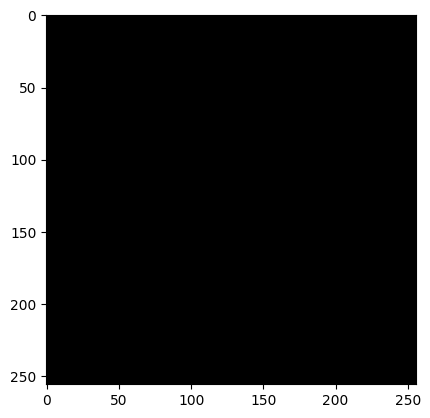

In [35]:
plt.imshow(rgb)

### TODO LIST:
- [x] Download Landsat8 data
- [x] Create a datasampler for the downloaded data
- [x] Load 256x256 patches from the datasampler
- [x] Scale images
- [x] Take out RGB bands 3 - R, 2 - G, 1 - B to plot
- [] Download Crop Data Layer (CDL) data
- [] Download more Landsat8 data
- [] Merge CDL data with Landsat8 data using TorchGeo's & operator
- [] Create a dataloader
- [] Create a model

In [20]:
# import rasterio
# from matplotlib import pyplot
# src = rasterio.open("..\Data\Remote Sensing\itqan.tif")
# pyplot.imshow(src.read(1))
# pyplot.show()

### Concatenated CDL data and Iowa Data

In [21]:
train_data = cdl & iowa

Converting Landsat8 CRS from EPSG:32615 to EPSG:5070


In [22]:
new_sampler = RandomGeoSampler(train_data, size=512, length=5)

In [23]:
sample = next(iter(new_sampler))

In [24]:
mask = train_data[sample]['mask'].numpy().transpose(1, 2, 0)

In [25]:
arb = scale_image(train_data[sample])
img = arb['image'][[3, 2, 1], :, :, ]
img = img.numpy()
img = img.transpose(1, 2, 0)
img.shape   

(512, 512, 3)

### Plotting Satellite Image and its corresponding CDL data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


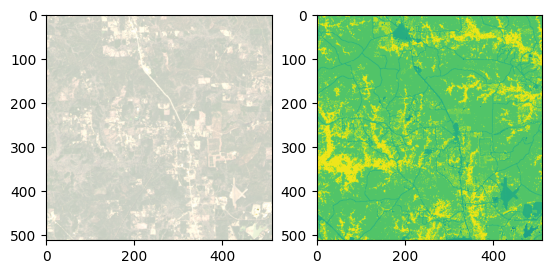

In [26]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(img)
ax2.imshow(mask)

In [202]:
np.unique(mask)

array([  1,   3,   5,  37,  74, 111, 121, 122, 123, 124, 131, 141, 142,
       143, 152, 176, 190, 195], dtype=int64)

In [197]:
# open new.tif
with rasterio.open("..\Data\Remote Sensing\\clipped2.tif") as src:
    print(src.profile)
    img = src.read(1)



{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 255.0, 'width': 70, 'height': 80, 'count': 1, 'crs': CRS.from_epsg(3857), 'transform': Affine(30.0, 0.0, -11184155.006683785,
       0.0, -30.0, 4656165.108223336), 'blockxsize': 128, 'blockysize': 128, 'tiled': True, 'compress': 'lzw', 'interleave': 'band'}


In [200]:
np.unique(img)

array([ 24, 255], dtype=uint8)

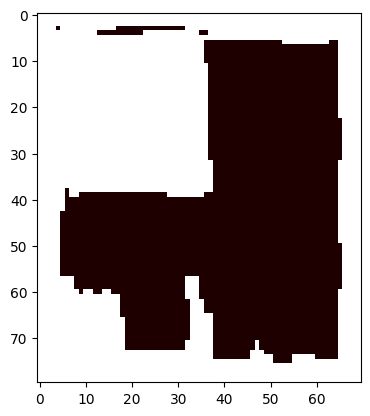

In [199]:
plt.imshow(img, cmap='pink')

array([  1,   5,  36,  37, 121, 122, 131, 141, 143, 176, 190, 195, 255],
      dtype=uint8)

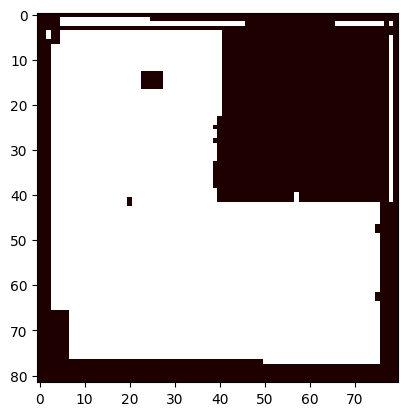

In [196]:
new = img == 1

plt.imshow(new, cmap='pink')